# The hydrodynamics of a probe holographic superconductor

## Equations

Import necessary packages

In [1]:
from sympy import *
from Einstein import Spacetime
from EquationsOfMotion import EOMs
from PseudospectralGrid import Grid
from Linearize import Linearize
from NewtonRaphson import ODE
from ODEEigenvalue import Eigenvalue
import numpy as np
import mpmath as mp
import time

Define variables and spacetime dimension

In [2]:
from sympy import symbols

r = symbols('r', positive=True)
t, x, y, dt, dr, dx, dy, M, q, mu, mus, omega, kwave = symbols(
    't x y dt dr dx dy M q mu mu_s omega k'
)

co = [t, r, x, y]
dco = [dt, dr, dx, dy]
dim = len(co)

Define line element and run Einstein module for GR quantities

In [3]:
f = Function('f')(r)
ds2 = (r**(-2))*(-f*(dt**2) + (dr**2)/f + dx**2 + dy**2)
spacetime = Spacetime(ds2, co, dco)

Define fields

In [4]:
Psi = Function('Psi')(*co)  # The scalar field
Psibar = Function('Psi^*')(*co)  # Complex conjugate

Amax = [
    Function('At')(*co),
    Function('Ar')(*co),
    Function('Ax')(*co),
    Function('Ay')(*co)
]  # The Maxwell field

Fab = [
    [
        diff(Amax[j], co[i]) - diff(Amax[i], co[j]) for j in range(dim)
    ] for i in range(dim)
]  # Field strength F_ab := d_a A_b - d_b A_a

# The complex scalar field, chosen to be just a function of r
psi = Function('psi')(r)

# Perturbations have plane wave dependence
sigmar = Function('sigma_r')(r)
sigmai = Function('sigma_i')(r)
deltapsi = (sigmar + I * sigmai) * exp(-I * (omega * t - kwave * x))
deltapsibar = (sigmar - I * sigmai) * exp(-I * (omega * t - kwave * x))

# Background Maxwell has A_t and A_x
phi = Function('phi')(r)
zeta = Function('zeta')(r)
Aback = [phi, 0, zeta, 0]

at = Function('at')(r)
ax = Function('ax')(r)
deltaA = [
    at * exp(-I * (omega * t - kwave * x)),
    0,
    ax * exp(-I * (omega * t - kwave * x)),
    0
]

background_fields = [psi, phi, zeta]
linear_fields = [sigmar, sigmai, at, ax]


Define Lagrangian, $\mathcal{L} = \sqrt{-g}\left(\frac{1}{4}F^2 + (\partial_\mu\Psi - iqA_\mu\Psi)(\partial^\mu\Psi^* + iqA^\mu\Psi^*) - V(\Psi,\Psi^*)\right)$ and fix $q=1$

In [5]:
# Fix q = 1
q = 1

# Define Lagrangian
root_det = (-1 * spacetime.det_met()) ** Rational(1, 2)
ginv = spacetime.inverse_metric()

Lag_max_kin = Rational(1, 4) * sum([
    sum([
        sum([
            sum([
                Fab[a][b] * Fab[c][e] * ginv[a, c] * ginv[b, e]
                for a in range(dim)
            ])
            for b in range(dim)
        ])
        for c in range(dim)
    ])
    for e in range(dim)
])

V_scalar = -(dim - 1) * (dim - 2) - 2 * Psi * Psibar

Lag_scalar = V_scalar + Rational(1, 2) * sum([
    sum([
        ginv[a, b] * (
            (diff(Psi, co[a]) - I * q * Amax[a] * Psi) *
            (diff(Psibar, co[b]) + I * q * Amax[b] * Psibar) +
            (diff(Psi, co[b]) - I * q * Amax[b] * Psi) *
            (diff(Psibar, co[a]) + I * q * Amax[a] * Psibar)
        )
        for a in range(dim)
    ])
    for b in range(dim)
])

Lag = simplify(-1 * root_det * (Lag_max_kin + Lag_scalar))

full_fields = [Psi, Psibar, Amax[0], Amax[1], Amax[2], Amax[3]]

eoms = EOMs(co, Lag, full_fields).get_eoms()

Find equations of motion for the background

In [6]:
back_subs = [
    (Psi, psi),
    (Psibar, psi),
    (Amax[0], Aback[0]),
    (Amax[1], 0),
    (Amax[2], Aback[2]),
    (Amax[3], 0),
]

# Redefine fields to extract boundary behavior
field_red = [
    (psi, r**2 * psi),
    (phi, phi * (1 - r)),
    (f, (1 - r) * (1 + r + r**2)),
]

eoms_red = [
    simplify(numer(eom.subs(back_subs).subs(field_red)))
    for eom in (eoms[0], eoms[2], eoms[4])
]

# Extract boundary behavior for better numerical stability
eoms_fin = [
    simplify(eoms_red[0] * (r**(-3)) / (1 - r)),
    simplify(eoms_red[1] * r**(-4) / (1 - r)),
    simplify(eoms_red[2] * r**(-4) / (1 - r)),
]

# Define boundary conditions
bcs_lower = [
    diff(psi, r).subs(r, 0),
    phi.subs(r, 0) - mu,
    zeta.subs(r, 0) - mus,
]

bcs_upper = [eoms_fin[i].subs(r, 1) for i in range(3)]

BCs = [
    [bcs_lower[0], bcs_upper[0]],
    [bcs_lower[1], bcs_upper[1]],
    [bcs_lower[2], bcs_upper[2]],
]

# Rewrite ODEs with coefficients of second derivatives equal to 1 for speed
odes = [
    psi.diff(r, r) - solve(Eq(eoms_fin[0], 0), psi.diff(r, r))[0],
    phi.diff(r, r) - solve(Eq(eoms_fin[1], 0), phi.diff(r, r))[0],
    zeta.diff(r, r) - solve(Eq(eoms_fin[2], 0), zeta.diff(r, r))[0],
]

Find equations of motion for the fluctuations

In [7]:
eps = symbols('epsilon')

linear_subs = [
    (Psi, psi + eps * deltapsi),
    (Psibar, psi + eps * deltapsibar),
    (Amax[0], Aback[0] + eps * deltaA[0]),
    (Amax[1], 0),
    (Amax[2], Aback[2] + eps * deltaA[2]),
    (Amax[3], 0),
]

linear_eoms = [
    simplify(numer(together(eq.subs(linear_subs).diff(eps).subs(eps, 0))))
    for eq in (eoms[0], eoms[1], eoms[2], eoms[3], eoms[4])
]

# Impose ingoing boundary conditions
ingoing_bcs = [
    (sigmar, sigmar * (1 - r) ** (-I * omega / 3)),
    (sigmai, sigmai * (1 - r) ** (-I * omega / 3)),
    (at, at * (1 - r) ** (-I * omega / 3)),
    (ax, ax * (1 - r) ** (-I * omega / 3)),
]

# Redefine fields
lin_field_red = [
    (sigmar, r * sigmar),
    (sigmai, r * sigmai),
    (at, (1 - r) * at),
]

linear_ing = [
    simplify(
        expand(
            simplify(
                expand(
                    (1 - r) ** (-2)
                    * numer(together(eom.subs(field_red).subs(ingoing_bcs).subs(lin_field_red)))
                )
            )
        )
    )
    for eom in linear_eoms
]

# Since we want hydrodynamic modes with lim_{k->0} omega(k) = 0, extract a k
linear_ing = [
    simplify(
        expand(simplify(numer(eq.subs(omega, kwave * omega))))
    )
    for eq in linear_ing
]

gauge_constraint = simplify(expand(linear_ing[3] / (r ** 2)))

# The actual linearized equations to be solved
linear_eoms = [
    simplify((1 - r) ** (-8) * linear_ing[0] / (r ** -3)),
    simplify((1 - r) ** (-8) * linear_ing[1] / (r ** -3)),
    simplify(linear_ing[2] / (r ** -2)),
    simplify(linear_ing[4] / (r ** -2)),
]

# Boundary conditions for linearized equations
bchor_0 = simplify(expand(simplify(expand(linear_eoms[0])))).subs(r, 1)
bchor_1 = simplify(expand(simplify(expand(linear_eoms[1])))).subs(r, 1)
bchor_2 = simplify(expand(simplify(expand(linear_eoms[2] / omega)))).subs(r, 1)
bchor_3 = simplify(expand(simplify(expand(linear_eoms[3])))).subs(r, 1)

uv_gauge_constraint = simplify(gauge_constraint.subs(r, 0))
ir_gauge_constraint = simplify(gauge_constraint.subs(r, 1) / (kwave * omega))

lin_bc_lower = [
    sigmar.subs(r, 0),
    sigmai.subs(r, 0),
    omega * ax.subs(r, 0) + at.subs(r, 0),
    uv_gauge_constraint,
]

lin_bc_upper = [bchor_0, bchor_1, bchor_2, bchor_3]

linear_bcs = [[lin_bc_lower[i], lin_bc_upper[i]] for i in range(len(lin_bc_lower))]


## Numerics

Set numerical precision and threshold for convergence

In [8]:
MIN_PRECISION = 24
mp.dps = MIN_PRECISION
ERROR_MIN = N(10**(-18), MIN_PRECISION)
ERROR_MAX = N(10**6, MIN_PRECISION)

Set up pseudospectral grid

In [9]:
# Spatial grid
NumPoints = 20
r_min, r_max = 0, 1
spatial_grid = Grid(NumPoints, r_min, r_max, MIN_PRECISION)
r_vec = spatial_grid.get_grid()

# Grid over chemical potential
Num_mu = 6
mu_min, mu_max = 5, 6
mu_grid = Grid(Num_mu, mu_min, mu_max, MIN_PRECISION)
mu_vec = mu_grid.get_grid()

# Grid over superfluid velocity
Num_mu_s = 6
mu_s_min, mu_s_max = N(10**(-6),MIN_PRECISION), N(10**(-4),MIN_PRECISION)
mu_s_grid = Grid(Num_mu_s, mu_s_min, mu_s_max, MIN_PRECISION)
mu_s_vec = mu_s_grid.get_grid()

Instantiate a Newton-Raphson solver

In [10]:
fields = [psi, phi, zeta]
dfields = [Function('dpsi')(r), Function('dphi')(r), Function('dzeta')(r)]
parameters = ['mu','mu_s']
ODEsolver = ODE(eoms_fin, BCs, fields, dfields, parameters, spatial_grid, r, [0,1])

Define seeds for the ODE solver

In [11]:
psi_vec = Matrix([N(15*(1-r_vec[i]**2),MIN_PRECISION) for i in range(NumPoints+1)])
phi_vec = Matrix([N(mu_min,MIN_PRECISION) for i in range(NumPoints+1)])
zeta_vec = Matrix([N(mu_s_min,MIN_PRECISION) for i in range(NumPoints+1)])
current_fields=[psi_vec, phi_vec, zeta_vec]

Loop over mu and solve the ODE

In [12]:
# sol_tab = [[[] for _ in range(Num_mu_s+1)] for _ in range(Num_mu+1)]
sol_tab = []
for i in range(Num_mu+1):
    mu_sol_tab = []
    for l in range(Num_mu_s+1):
        # Start with numpy arrays as this is much faster
        eps = 1
        while ERROR_MIN < eps < ERROR_MAX:
            df = ODEsolver.step(
                current_fields,
                {'mu': mu_vec[i], 'mu_s': mu_s_vec[l]},
                print_time=False,
                as_numpy=True,
            )
            eps = max(abs(df))
            for j in range(len(current_fields)):
                friction = 1 if eps < 1 else N(1 / 10, MIN_PRECISION)
                start_idx = j * (NumPoints + 1)
                end_idx = (j + 1) * (NumPoints + 1)
                current_fields[j] = current_fields[j] + friction * Matrix(df[start_idx:end_idx])
            print(i, l, eps)

        # Now use precision
        eps = 1
        while ERROR_MIN < eps < ERROR_MAX:
            df = ODEsolver.step(
                current_fields,
                {'mu': mu_vec[i], 'mu_s': mu_s_vec[l]},
                print_time=False,
                as_numpy=False,
            )
            eps = max(abs(df))
            for j in range(len(current_fields)):
                friction = 1 if eps < 1 else N(1 / 10, MIN_PRECISION)
                start_idx = j * (NumPoints + 1)
                end_idx = (j + 1) * (NumPoints + 1)
                current_fields[j] = current_fields[j] + friction * Matrix(df[start_idx:end_idx])
            print(i, l, eps)

        mu_sol_tab += [current_fields.copy()]
    sol_tab += [mu_sol_tab]

0 0 5.85837654431612
0 0 5.59525945827992
0 0 5.36343138304239
0 0 5.13903982979767
0 0 4.92177126539502
0 0 4.71131639179914
0 0 4.51943711429245
0 0 4.33854593991733
0 0 4.16714549332607
0 0 4.00818006736885
0 0 3.86089907758649
0 0 3.71923529340051
0 0 3.57727638014579
0 0 3.43513177647535
0 0 3.29315722704224
0 0 3.15169399067327
0 0 3.01107128004675
0 0 2.87160814678474
0 0 2.73361489065708
0 0 2.59739404714183
0 0 2.46324098066992
0 0 2.33144408114934
0 0 2.20228453759706
0 0 2.07603564645274
0 0 1.95296161012466
0 0 1.83331579424505
0 0 1.71733844280488
0 0 1.60525389439571
0 0 1.49726739766722
0 0 1.39356168106378
0 0 1.29429348151056
0 0 1.19959027183110
0 0 1.10954743742385
0 0 1.02422613646146
0 0 0.943652035152678
0 0 0.109402312073267
0 0 0.00175083952769586
0 0 3.44562818719398e-7
0 0 2.88561595387387e-14
0 0 1.28177416870951e-23
0 0 1.11463968366662211992164e-23
0 1 6.63174251267032e-6
0 1 2.00240646301492e-11
0 1 1.07127979643504e-22
0 1 2.06409568984612562087453e-23
0 

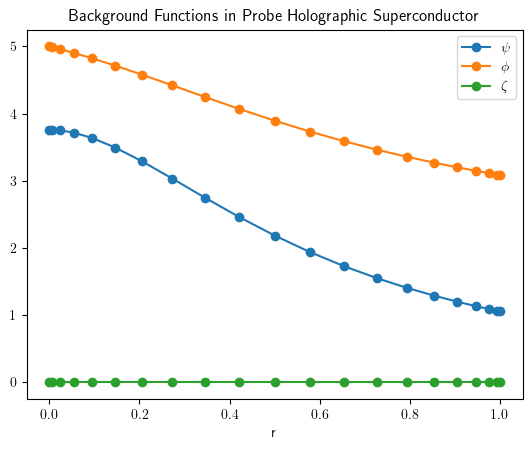

In [13]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

plt.plot(r_vec, sol_tab[0][0][0], '-o', label=r'$\psi$')
plt.plot(r_vec, sol_tab[0][0][1], '-o', label=r'$\phi$')
plt.plot(r_vec, sol_tab[0][0][2], '-o', label=r'$\zeta$')
plt.xlabel('r')
plt.legend()
plt.title("Background Functions in Probe Holographic Superconductor")
plt.show()

In [14]:
Otab = [[sol_tab[i][j][0][0] for j in range(Num_mu_s+1)] for i in range(Num_mu+1)]

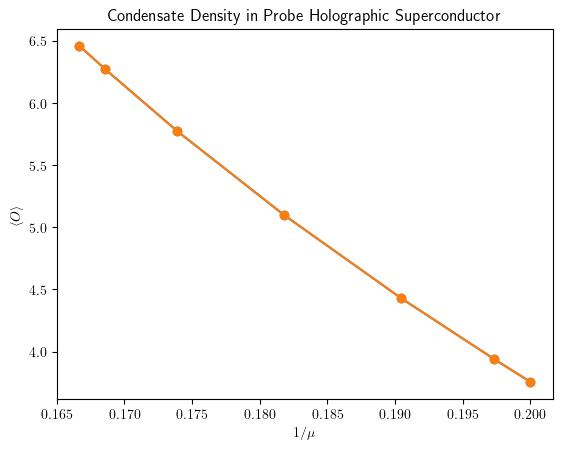

In [15]:
plt.plot([1/mu_vec[k] for k in range(Num_mu+1)], [Otab[k][0] for k in range(Num_mu+1)], '-o')
plt.plot([1/mu_vec[k] for k in range(Num_mu+1)], [Otab[k][1] for k in range(Num_mu+1)], '-o')
plt.xlabel(r'$1/\mu$')
plt.ylabel(r'$\langle O \rangle$')
plt.title("Condensate Density in Probe Holographic Superconductor")
plt.show()

### Find Quasinormal Modes

Instantiate Linear Solver

In [16]:
# Instantiate a solver
lin_fields = [sigmar, sigmai, at, ax]
dlin_fields = [Function('dsigma_r')(r), Function('dsigma_i')(r), Function('dat')(r), Function('dax')(r)]
lin_parameters=[kwave]

lin_sol_tab = []
lin_solver = Eigenvalue(
    linear_eoms, 
    linear_bcs, 
    lin_fields, 
    dlin_fields, 
    fields, 
    lin_parameters, 
    omega, 
    spatial_grid, 
    r, 
    [0,1],
    precision = MIN_PRECISION)

In [17]:
Nk = 10
k_min, k_max = N(10**(-3),MIN_PRECISION), N(10**(-1),MIN_PRECISION)
k_grid = Grid(Nk, k_min, k_max, MIN_PRECISION)
k_tab = k_grid.get_grid()
eigs_tab = [[[[] for k in range(Nk+1)] for j in range(Num_mu_s)] for i in range(Num_mu)]

Find eigenvalues of the generalized eigenvalue problem. If as_numpy = False, this will refine the numpy eigenvalues using Newton refinement. Note that the refinement is quite slow. You can select eigenvalues to refine based on their norm using max_norm. 

In [18]:
# for l in range(Num_mu):
#     for j in range(Num_mu_s):
for l in range(1):
    for j in range(1):
        for i in range(Nk+1):
            start = time.time()
            eigs_tab[l][j][i]=lin_solver.find_eigenvalue(
                sol_tab[l][j],
                {kwave: k_tab[i]}, 
                print_time = False, 
                as_numpy = False,
                precision = MIN_PRECISION,
                max_norm = 2).copy()
            end = time.time()
            print(f"step {i}: {end-start} seconds")

step 0: 24.90515923500061 seconds
step 1: 25.134002923965454 seconds
step 2: 24.81985116004944 seconds
step 3: 24.860909938812256 seconds
step 4: 24.83626389503479 seconds
step 5: 25.0452983379364 seconds
step 6: 24.924224853515625 seconds
step 7: 144.35077619552612 seconds
step 8: 24.87245488166809 seconds
step 9: 25.001044988632202 seconds
step 10: 25.586779832839966 seconds


Look for possible hydrodynamic modes

In [21]:
possible_modes = [[[[] for _ in range(Nk+1)] for j in range(Num_mu_s)] for i in range(Num_mu)]

for l in range(Num_mu):
    for m in range(Num_mu_s):
        for i in range(Nk+1):
            for j in range(len(eigs_tab[l][m][i])):
                if np.isnan(np.complex128(eigs_tab[l][m][i][j])):
                    pass
                elif 10**(-1) < np.abs(np.complex128(eigs_tab[l][m][i][j])) < 1:
                    possible_modes[l][m][i]+=[np.complex128(eigs_tab[l][m][i][j])]

In [22]:
possible_modes[0][0]

[[(0.6290506162164075+0.04754037838490752j),
  (-0.6273583193407632+0.050924173915642766j),
  (0.0018972811209746214+0.722160723782582j),
  (-0.003603283001275406-0.1879971762040705j)],
 [(-0.582393543416705+0.00980758257982134j),
  (0.01006032982438173+0.27458891407254815j),
  (0.5841505941709496+0.0029642445229442877j),
  (-0.01180943776685856-0.1027874586619834j)],
 [(0.5606753354588966-0.0007579579982961385j),
  (-0.5606768057574278-0.0007660548702318925j)],
 [(0.5607212024563033-0.0015487673778037806j),
  (-0.5607216075993899-0.0015487362385294308j)],
 [(-0.5607274580718532-0.002517235082435451j),
  (0.5607317873410631-0.0025739811882999823j)],
 [(0.5607240871379542-0.003648831164134445j),
  (-0.5607247182758566-0.0036510237801683676j)],
 [(0.5607185789369163-0.004753610635143336j),
  (-0.5607186519105699-0.0047504949687461944j)],
 [(0.560714867642217-0.005744269475284435j),
  (-0.5607150773967099-0.005742749456355433j)],
 [(-0.5607131430379011-0.006527266034725042j),
  (0.5607129

Plot the result

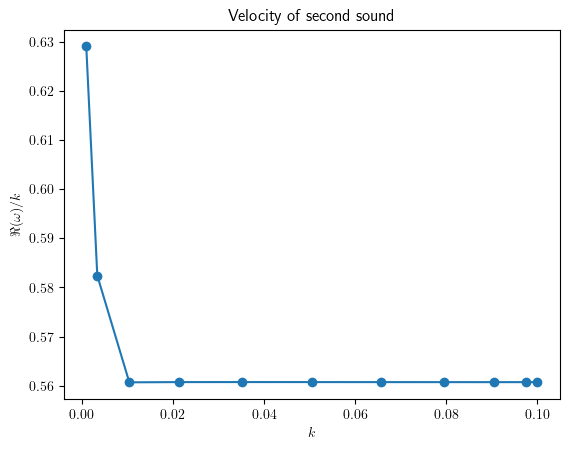

In [32]:
plt.plot(k_tab,[np.abs(possible_modes[0][0][k][0].real) for k in range(Nk+1)], '-o')
plt.xlabel(r'$k$')
plt.ylabel(r'$\Re(\omega)/k$')
plt.title("Velocity of second sound")
plt.show()

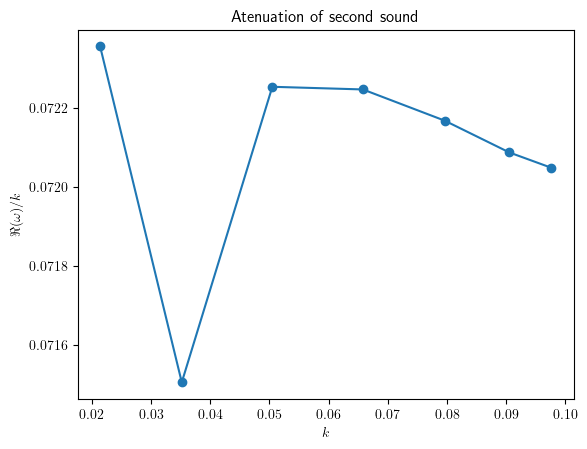

In [24]:
plt.plot(k_tab[3:-1],[np.abs(possible_modes[0][0][k][0].imag)/k_tab[k] for k in range(3,Nk)], '-o')
plt.xlabel(r'$k$')
plt.ylabel(r'$\Re(\omega)/k$')
plt.title("Atenuation of second sound")
plt.show()

### Hydrodynamics

An example of calculating second sound velocity

In [25]:
rho_tab = [[sol_tab[i][j][1][0]-(spatial_grid.D1()[0,:]*sol_tab[i][j][1])[0] for j in range(Num_mu_s+1)] for i in range(Num_mu+1)]
Jx_tab = [[-(spatial_grid.D1()[0,:]*sol_tab[i][j][2])[0] for j in range(Num_mu_s+1)] for i in range(Num_mu+1)]
rho_s_tab = [[mu_vec[k]/mu_s_vec[j]*Jx_tab[k][j] for j in range(Num_mu_s+1)] for k in range(Num_mu+1)]
drho_dzeta = [[(mu_s_grid.D1()[k,:]*Matrix(rho_tab[j]))[0] for k in range(Num_mu_s+1)] for j in range(Num_mu+1)]
drho_dmu = [[(mu_grid.D1()[j,:]*Matrix(rho_tab)[:,k])[0] for k in range(Num_mu_s+1)] for j in range(Num_mu+1)]
drho_s_dzeta = [[(mu_s_grid.D1()[k,:]*Matrix(rho_s_tab[j]))[0] for k in range(Num_mu_s+1)] for j in range(Num_mu+1)]

In [26]:
chi_nsh, rho_s, chi_nh, chi_nn = symbols('chi_nsh rho_s chi_nh chi_nn')
chi_xi_xi = mu/(mus*chi_nsh+rho_s)
velocity_minus = chi_nh/chi_nn - sqrt(chi_nh**2/chi_nn**2+1/(chi_nn*chi_xi_xi))

In [27]:
velocity_minus

chi_nh/chi_nn - sqrt(chi_nh**2/chi_nn**2 + (chi_nsh*mu_s + rho_s)/(chi_nn*mu))

In [28]:
v_min_tab = [
    [velocity_minus
     .subs(chi_nsh,drho_s_dzeta[i][j])
     .subs(chi_nn,drho_dmu[i][j])
     .subs(chi_nh,drho_dzeta[i][j])
     .subs(mus,mu_s_vec[j])
     .subs(mu,mu_vec[i])
     .subs(rho_s,rho_s_tab[i][j]) 
     for j in range(Num_mu_s+1)] 
     for i in range(Num_mu+1)]

Check the matching

In [29]:
v_min_tab[0][0]

-0.560721885180846653399142

In [30]:
possible_modes[0][0][-1]

[(-0.5607130148589836-0.007203317326413677j),
 (0.5607125954448232-0.007203327864546594j)]

So they match to high accuracy!